In [ ]:
!git clone https://github.com/douglasyao/FR-Perturb.git

Cloning into 'FR-Perturb'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 113 (delta 62), reused 51 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 78.95 KiB | 2.39 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
# micromamba activate frp
# python -m pip install --upgrade pip
# python -m pip install jupyterlab notebook jupyter ipykernel

# jupyter notebook --no-browser --ip=127.0.0.1 --port=8890


In [ ]:
# # A) Ensure micromamba is available in this session
# eval "$($HOME/bin/micromamba shell hook -s bash)"   # no output is fine

# # B) Go to the repo where environment.yml lives
# cd ~/FR-Perturb
# ls -l environment.yml                               # should list the file

# # C) Create the env from YAML (use repo path explicitly)
# micromamba create -y -n frp -f environment.yml

# # D) Activate the env (now 'python' exists)
# micromamba activate frp

# # E) (Once) register as a Jupyter kernel
# python -m ipykernel install --user --name frp --display-name "FR-Perturb"

# # F) Verify
# python -V
# pip -V

In [ ]:
# mkdir -p outputs
# ./run_FR_Perturb.py \
#   --input-h5ad counts.h5ad \
#   --input-perturbation-matrix perturb_matrix.tsv \
#   --control-perturbation-name control \
#   --out outputs/tumor_FRP

In [ ]:
!pip install matplotlib seaborn pandas numpy 

In [4]:
!pip install --user scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 17.7 MB/s eta 0:00:000:00:0136m0:00:01


In [ ]:
# build_inputs_from_C_and_P0.py
# import pandas as pd, numpy as np, scipy.sparse as sp, anndata as ad

# counts_csv = "/u/jchen67/Tumor_data/matched_merfishcounttable_xy.csv"
# perts_csv  = "/u/jchen67/Tumor_data/tumorpooledperturbations.csv"
# out_h5ad   = "counts.h5ad"
# out_perts  = "perturb_matrix.tsv"

# # --- counts (rows=cells) ---
# C = pd.read_csv(counts_csv)
# assert {"cell_id"}.issubset(C.columns)
# C = C.drop_duplicates("cell_id", keep="first").reset_index(drop=True)
# cells = C["cell_id"].astype(str)

# gene_cols = [c for c in C.columns if c not in ("cell_id","X","Y")]
# G = C[gene_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
# G.index = cells
# X = sp.csr_matrix(G.values)

# # optional coords (won’t fail if missing)
# def _num(s):
#     try: return float(str(s).replace(",",""))
#     except: return np.nan
# if "X" in C and "Y" in C:
#     Xcoord = C["X"].map(_num)
#     Ycoord = C["Y"].map(_num)
# else:
#     Xcoord = pd.Series(np.nan, index=cells)
#     Ycoord = pd.Series(np.nan, index=cells)

# # --- perts (your P0 layout: first col = guide name, other cols = Cell_#) ---
# P0 = pd.read_csv(perts_csv)
# idx0 = P0.columns[0]                    # "Unnamed: 0"
# P0 = P0.set_index(idx0)

# # transpose to rows=cells, cols=perts
# W = P0.T.copy()

# # normalize cell IDs to match counts: "Cell_####" -> "cell_####"
# W.index = (W.index.astype(str)
#               .str.strip()
#               .str.replace(r"^Cell_", "cell_", regex=True))

# # align to counts order and binarize
# W = W.reindex(cells, fill_value=0)
# W = (W.fillna(0).astype(float) > 0).astype(np.int8)

# # control column: rename or derive
# if "Control" in W.columns: W = W.rename(columns={"Control":"control"})
# if "control" not in W.columns:
#     W["control"] = (W.sum(axis=1) == 0).astype(np.int8)

# # drop empty perts (keep control)
# keep = [c for c in W.columns if c=="control" or W[c].sum()>0]
# W = W[keep]
# assert W.shape[1] > 0, "no perturbation columns after alignment"

# # --- write counts.h5ad ---
# adata = ad.AnnData(X=X)
# adata.obs_names = cells.astype(str).tolist()
# adata.var_names = gene_cols
# adata.layers["counts"] = adata.X.copy()
# adata.obs["total_counts"] = np.asarray(X.sum(axis=1)).ravel()
# adata.obs["X"] = Xcoord.values
# adata.obs["Y"] = Ycoord.values
# adata.obsm["spatial"] = np.c_[adata.obs["X"].values, adata.obs["Y"].values]
# adata.write(out_h5ad)

# # --- write perturb_matrix.tsv ---
# PW = W.loc[adata.obs_names].copy()
# PW.insert(0, "Cell_Barcode", adata.obs_names)
# PW.to_csv(out_perts, sep="\t", index=False)

# # --- quick diagnostics ---
# unmatched = set(W.index) - set(adata.obs_names)
# print(f"cells: {adata.n_obs}, genes: {adata.n_vars}, perts: {PW.shape[1]-1}")
# print("unmatched cells in perts (should be 0):", len(unmatched))
# print("top perts:\n", PW.drop(columns=["Cell_Barcode"]).sum().sort_values(ascending=False).head(8))

In [1]:
# prep_inputs.py  (NaN-safe, tumor settings)
import pandas as pd, numpy as np, scipy.sparse as sp, anndata as ad
import re

counts_csv = "/u/jchen67/Tumor_data/matched_merfishcounttable_xy.csv"
perts_csv  = "/u/jchen67/Tumor_data/tumorpooledperturbations.csv"
out_h5ad   = "counts.h5ad"
out_perts  = "perturb_matrix.tsv"

# --- counts ---
C = pd.read_csv(counts_csv)
assert {"cell_id"}.issubset(C.columns), "need cell_id"
C = C.drop_duplicates("cell_id", keep="first").reset_index(drop=True)
cells = C["cell_id"].astype(str)

gene_cols = [c for c in C.columns if c not in ("cell_id","X","Y")]
assert len(gene_cols) > 0, "no gene columns"
G = C[gene_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
G.index = cells

# --- perts (first col = guide name; other cols = Cell_#) ---
P0 = pd.read_csv(perts_csv)
idx0 = P0.columns[0]
P0 = P0.set_index(idx0).T
# normalize cell IDs: "Cell_123" -> "cell_123"
P0.index = (P0.index.astype(str).str.strip()
            .str.replace(r"^Cell_", "cell_", regex=True))

W = P0.reindex(cells, fill_value=0)
W = (W.fillna(0).astype(float) > 0).astype(np.int8)

# control column
if "Control" in W.columns:
    W = W.rename(columns={"Control": "control"})
if "control" not in W.columns:
    W["control"] = (W.sum(axis=1) == 0).astype(np.int8)

# drop empty perts (keep control)
keep = ["control"] + [c for c in W.columns if c != "control" and W[c].sum() > 0]
W = W[keep]
assert W["control"].sum() > 0, "no control cells"

# --- gene prefilter to avoid NaNs in FR-Perturb scaling ---
ctrl_mask = W["control"].astype(bool).values
# keep genes with any counts overall
nz = (G.sum(axis=0) > 0).values
# keep genes with non-zero variance in controls
if ctrl_mask.any():
    var_ok = (G.loc[ctrl_mask, :].var(axis=0) > 0).values
else:
    var_ok = np.ones(G.shape[1], dtype=bool)

good_genes = [g for g, a, b in zip(gene_cols, nz, var_ok) if a and b]
G = G[good_genes]
gene_cols = good_genes
assert len(gene_cols) > 0, "all genes filtered out"

# --- build AnnData ---
X = sp.csr_matrix(G.values)
adata = ad.AnnData(X=X)
adata.obs_names = cells.tolist()
adata.var_names = gene_cols
adata.layers["counts"] = adata.X.copy()
adata.obs["total_counts"] = np.asarray(X.sum(axis=1)).ravel()  # covariate in paper

# robust X/Y parse (optional)
def _num(v):
    try:
        s = str(v).strip().replace(",", "")
        s = re.sub(r"[^0-9.+-eE]", "", s)
        return float(s) if s else np.nan
    except:
        return np.nan

if "X" in C and "Y" in C:
    adata.obs["X"] = C["X"].map(_num).values
    adata.obs["Y"] = C["Y"].map(_num).values
    adata.obsm["spatial"] = np.c_[adata.obs["X"], adata.obs["Y"]]
else:
    adata.obs["X"] = np.nan
    adata.obs["Y"] = np.nan
    adata.obsm["spatial"] = np.c_[adata.obs["X"], adata.obs["Y"]]

adata.write(out_h5ad)

# --- perturb_matrix.tsv (rows=cells) ---
PW = W.loc[adata.obs_names].copy()
PW.insert(0, "Cell_Barcode", adata.obs_names)
PW.to_csv(out_perts, sep="\t", index=False)

print(f"Wrote {out_h5ad}: {adata.n_obs} cells × {adata.n_vars} genes")
print(f"Wrote {out_perts}: {PW.shape[0]} rows × {PW.shape[1]-1} perts")
print("Top perts:\n", PW.drop(columns=["Cell_Barcode"]).sum().sort_values(ascending=False).head(8))

Wrote counts.h5ad: 9432 cells × 500 genes
Wrote perturb_matrix.tsv: 9432 rows × 36 perts
Top perts:
 Unnamed: 0
control    4398
IRF3        465
IRF5        416
IRAK4       400
IRF7        340
MAP2K2      330
MAP2K6      318
MAP2K3      254
dtype: int64


/tmp/ipykernel_125406/63520025.py:60: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X)


In [2]:
import anndata as ad
a = ad.read_h5ad("counts.h5ad")
a

AnnData object with n_obs × n_vars = 9432 × 500
    obs: 'total_counts', 'X', 'Y'
    obsm: 'spatial'
    layers: 'counts'

In [3]:
adata.obs.head()

total_counts           X              Y
cell_1            48   87.561842  136197.870810
cell_2            98  100.038085  140438.670907
cell_3           416  200.362184  139500.293533
cell_4           304  144.921319  139788.104339
cell_5           110  163.934023  128884.449827

In [4]:
import anndata as ad, pandas as pd
P = pd.read_csv("perturb_matrix.tsv", sep="\t")

P.head()

Cell_Barcode  control  CD14  CHUK  IKBKB  IRAK1  IRAK4  IRF3  IRF5  IRF7  \
0       cell_1        0     0     0      0      0      0     0     0     1   
1       cell_2        0     0     0      0      0      0     0     0     0   
2       cell_3        1     0     0      0      0      0     0     0     0   
3       cell_4        1     0     0      0      0      0     0     0     0   
4       cell_5        0     0     0      0      0      0     0     1     0   

   ...  RIPK1  TAB1  TAB2  TBK1  TICAM1  TIRAP  TLR4  TRADD  TRAF6  TRAM1  
0  ...      0     0     0     0       0      0     0      0      0      0  
1  ...      0     0     0     0       0      0     0      0      1      0  
2  ...      0     0     0     0       0      0     0      0      0      0  
3  ...      0     0     0     0       0      0     0      0      0      0  
4  ...      0     0     0     0       0      0     0      0      0      0  

[5 rows x 37 columns]

In [5]:
import pandas as pd
df = pd.read_csv("perturb_matrix.tsv", sep="\t")
print(df["control"].sum(), "cells are control")
print((df.drop(columns=["Cell_Barcode","control"]).sum(axis=1) > 0).sum(), "cells are treated")

4398 cells are control
5168 cells are treated


In [ ]:
# # frp_preflight_strict.py
# # Drop only genes that become invalid after FR-Perturb's own pre-steps
# # (TP10K->log1p, regress total_counts, center & scale by controls).

# import numpy as np, pandas as pd, anndata as ad, scipy.sparse as sp

# H5_IN  = "counts.h5ad"          # your current file
# PERTS  = "perturb_matrix.tsv"   # matches H5 obs_names
# H5_OUT = "counts.clean.h5ad"
# MIN_PER = 10  # keep control regardless

# A = ad.read_h5ad(H5_IN)
# P = pd.read_csv(PERTS, sep="\t").set_index("Cell_Barcode").loc[A.obs_names]

# # keep control + reasonably sized perts (doesn't change genes, just robustness)
# keep = ["control"] + [c for c in P.columns if c!="control" and P[c].sum()>=MIN_PER]
# P = P[keep]
# ctrl = P["control"].to_numpy(bool)
# assert ctrl.sum() > 0, "no control cells"

# # --- 1) TP10K -> log1p ---
# X = A.layers["counts"] if "counts" in A.layers else A.X
# if sp.issparse(X): X = X.tocsr()
# X = X.astype(np.float64)
# tot = np.asarray(X.sum(axis=1)).ravel()
# tot[tot <= 0] = 1.0
# tp10k = (X / tot[:, None]) * 1e4
# tp10k = tp10k.toarray() if sp.issparse(tp10k) else tp10k
# Y = np.log1p(tp10k)  # (n_cells x n_genes)

# # --- 2) regress total_counts (intercept + covariate) ---
# cov = A.obs.get("total_counts", pd.Series(tot, index=A.obs_names)).to_numpy().astype(np.float64)
# Z = np.c_[np.ones((Y.shape[0],1)), cov.reshape(-1,1)]
# beta = np.linalg.pinv(Z.T @ Z) @ (Z.T @ Y)
# Yres = Y - Z @ beta

# # --- 3) center & scale by controls ---
# ctrl_res = Yres[ctrl, :]                       # (n_ctrl x n_genes)
# mu  = np.nanmean(ctrl_res, axis=0)             # (n_genes,)
# sd  = np.nanstd (ctrl_res, axis=0, ddof=0)     # (n_genes,)

# # boolean mask of "bad" genes; ensure 1-D and correct length
# bad = ((~np.isfinite(mu)) | (~np.isfinite(sd)) | (sd <= 0.0))
# bad = np.asarray(bad, dtype=bool).ravel()
# assert bad.size == A.n_vars, f"mask len {bad.size} != n_genes {A.n_vars}"

# # get indices / names safely
# bad_idx   = np.where(bad)[0]
# bad_genes = A.var_names.take(bad_idx).tolist()

# print(f"Genes that would create NaNs after scaling: {bad.sum()} of {A.n_vars}")
# if bad_genes[:10]:
#     print("Example:", bad_genes[:10])

# # --- 4) write cleaned h5ad (drop only the bad ones) ---
# keep_mask = ~bad
# A_clean = A[:, keep_mask].copy()
# A_clean.write("counts.clean.h5ad")
# print(f"Wrote counts.clean.h5ad: {A_clean.n_obs} cells × {A_clean.n_vars} genes")


In [6]:
! ./run_FR_Perturb.py \
  --input-h5ad counts.h5ad \
  --input-perturbation-matrix perturb_matrix.tsv \
  --control-perturbation-name control \
  --covariates total_counts \
  --rank 26 --lasso-alpha 0.6 --spca-alpha 2 \
  --compute-pval \
  --out outputs/tumor_FRP


23:22:36 __main__ INFO: *********************************************************************
* Factorize-Recover for Perturb-seq analysis (FR-Perturb)
* by Douglas Yao 2022 
*********************************************************************
Call: 
./run_FR_perturb.py \
--input-h5ad counts.h5ad \
--out outputs/tumor_FRP \
--input-perturbation-matrix perturb_matrix.tsv \
--covariates total_counts \
--control-perturbation-name control \
--compute-pval  \
--rank 26 \
--spca-alpha 2.0 \
--lasso-alpha 0.6 

23:22:36 __main__ INFO: Beginning analysis at Mon Oct 13 23:22:36 2025
23:22:36 __main__ INFO: Loading input h5ad from counts.h5ad...  
23:22:36 __main__ INFO: Loading input perturbation matrix from perturb_matrix.tsv...  
23:22:36 __main__ INFO: Filtered 0 genes with 0 expression across all cells
23:22:36 __main__ INFO: Filtered 0 cells with 0 expression across all genes
23:22:36 __main__ INFO: Retained 9432 cells and 500 genes for analysis
23:22:36 __main__ INFO: Converting raw coun

In [7]:
import pandas as pd, numpy as np, os

# Choose one (or both for split-triangle)
LOW  = "outputs/tumor_low_FRP_LFCs.txt"
HIGH = "outputs/tumor_high_FRP_LFCs.txt"

assert os.path.exists(LOW),  f"File not found: {LOW}"
assert os.path.exists(HIGH), f"File not found: {HIGH}"

M_low  = pd.read_csv(LOW, sep="\t", index_col=0)
M_high = pd.read_csv(HIGH, sep="\t", index_col=0)

print("Low:",  M_low.shape, "High:", M_high.shape)
print("Rows:", len(M_low.index), "Cols:", len(M_low.columns))
print("First few rows:\n", M_low.iloc[:3, :5])

Low: (500, 36) High: (500, 36)
Rows: 500 Cols: 36
First few rows:
          CD14   CHUK     IKBKB  IRAK1    IRAK4
PDK4   -0.472 -0.472  0.000702 -0.353 -0.02460
CCL26  -0.984 -0.385 -0.165000 -0.195 -0.00778
CX3CL1 -0.234 -0.270 -0.371000 -0.674  0.02380


Rows missing from data: ['EBI3', 'EHD1', 'TNFAIP3', 'TNFAIP2', 'RHOB', 'IFIT3', 'ETS2', 'RSAD2', 'TOP2A', 'ANP32E', 'CBX5', 'HMGB2', 'SMC4', 'MCM4', 'RRM2', 'FEN1', 'CDCA5', 'CDC45', 'IL1A', 'ORAI2', 'SLA', 'ZNFX1', 'IFI44', 'IFIH1', 'ZC3H12C', 'ACSL1', 'SLC7A11', 'OSGIN2', 'EDEM1', 'ST3GAL1', 'NLRP3', 'GADD45B', 'SWA70', 'SLC39A14', 'PML', 'MLLT6', 'ELL2', 'NAMPT', 'GBP3', 'EIF2AK2', 'LBR', 'PARP4', 'SAMD9L', 'USP18', 'MOV10', 'IFI35', 'PHF11', 'TOP1', 'RFC2', 'BLOC1S2', 'YME1L1', 'INF2', 'AIFM1', 'KPNA3', 'NSUN2', 'ARHGAP4', 'TOR3A', 'RANGAP1', 'NFKBIB', 'EIF2B3', 'UBR4', 'SLC30A7', 'HSD17B11', 'CRLF3', 'ZNF615', 'RAB8B', 'STK38', 'CCNYL1', 'SNRNP48', 'CACHD1', 'TBXA2R', 'RBM7', 'PEX11B', 'TMC8', 'TRIM59', 'ZNF77', 'SNCB', 'ZNF708', 'BACH2', 'INP5K', 'GTDC1', 'NCK1', 'KIF9', 'CIR1', 'MPND', 'SBDS', 'GSPT1', 'PHACTR1', 'TRIM13', 'HLA-G', 'MITD1', 'ARHGEF3', 'MGAT4B', 'SH3BP5', 'MTMR6', 'GPX7', 'GALNT12', 'RAB2B', 'COQ10B', 'ARL13B', 'IQGAP3', 'TACC3', 'CDCA8', 'CTCF', 'CKAP5', 'SETD3'

/tmp/ipykernel_84351/572851977.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: outputs/heatmap_fig4B_final.png


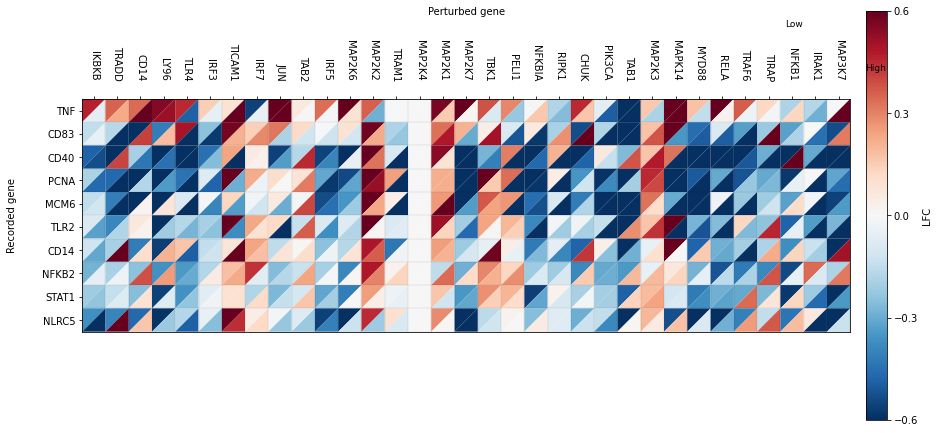

In [7]:
# === Final Fig. 4B-style split-triangle heat map ===
# Uses fixed order and paper-style axis placement/colors
# Output: outputs/heatmap_fig4B_final.png

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib import cm

LOW_PATH  = "outputs/tumor_low_FRP_LFCs.txt"
HIGH_PATH = "outputs/tumor_high_FRP_LFCs.txt"
OUT_PNG   = "outputs/heatmap_fig4B_final.png"

# --- fixed orders (edit if you want different ones) ---
ROW_ORDER = [
    "TNF","EBI3","CD83","EHD1","TNFAIP3","TNFAIP2","CD40","RHOB","IFIT3","ETS2",
    "RSAD2","TOP2A","ANP32E","CBX5","HMGB2","SMC4","MCM4","RRM2","FEN1","CDCA5",
    "PCNA","MCM6","CDC45","IL1A","ORAI2","SLA","ZNFX1","IFI44","IFIH1","ZC3H12C",
    "ACSL1","TLR2","SLC7A11","OSGIN2","EDEM1","ST3GAL1","NLRP3","CD14","GADD45B",
    "SWA70","SLC39A14","NFKB2","PML","MLLT6","ELL2","NAMPT","GBP3","EIF2AK2","LBR",
    "STAT1","PARP4","SAMD9L","USP18","MOV10","NLRC5","IFI35","PHF11","TOP1","RFC2",
    "BLOC1S2","YME1L1","INF2","AIFM1","KPNA3","NSUN2","ARHGAP4","TOR3A","RANGAP1",
    "NFKBIB","EIF2B3","UBR4","SLC30A7","HSD17B11","CRLF3","ZNF615","RAB8B","STK38",
    "CCNYL1","SNRNP48","CACHD1","TBXA2R","RBM7","PEX11B","TMC8","TRIM59","ZNF77",
    "SNCB","ZNF708","BACH2","INP5K","GTDC1","NCK1","KIF9","CIR1","MPND","SBDS",
    "GSPT1","PHACTR1","TRIM13","HLA-G","MITD1","ARHGEF3","MGAT4B","SH3BP5","MTMR6",
    "GPX7","GALNT12","RAB2B","COQ10B","ARL13B","IQGAP3","TACC3","CDCA8","CTCF",
    "CKAP5","SETD3","CHD1","ETNK1","RPRD2","ARHGAP25","FOXN3","TRERF1","PLEKHA2",
    "ETV3","LCP2"
]

COL_ORDER = [
    "IKBKB","TRADD","CD14","LY96","TLR4","IRF3","TICAM1","IRF7","JUN","TAB2",
    "IRF5", "MAP2K6","MAP2K2","TRAM1","MAP2K4","MAP2K1","MAP2K7","TBK1","PELI1",
    "NFKBIA","RIPK1","CHUK","PIK3CA","TAB1","MAP2K3","MAPK14","MYD88","RELA","TRAF6",
    "TIRAP","NFKB1","IRAK1","MAP3K7"
]

# ---- load matrices ----
assert os.path.exists(LOW_PATH),  f"Missing: {LOW_PATH}"
assert os.path.exists(HIGH_PATH), f"Missing: {HIGH_PATH}"
L0 = pd.read_csv(LOW_PATH,  sep="\t", index_col=0)
H0 = pd.read_csv(HIGH_PATH, sep="\t", index_col=0)

# report missing items vs your fixed order
missing_rows = [g for g in ROW_ORDER if g not in L0.index or g not in H0.index]
missing_cols = [g for g in COL_ORDER if g not in L0.columns or g not in H0.columns]
if missing_rows: print("Rows missing from data:", missing_rows)
if missing_cols: print("Cols missing from data:", missing_cols)

# keep only those present, preserve your fixed order
rows = [g for g in ROW_ORDER if g in L0.index and g in H0.index]
cols = [g for g in COL_ORDER if g in L0.columns and g in H0.columns]
assert rows and cols, "After intersecting with data, no rows/cols remain — check names."
L = L0.loc[rows, cols].copy()
H = H0.loc[rows, cols].copy()

# ---- color scale ----
USE_FIXED_RANGE = True       # set False to auto (99th percentile)
if USE_FIXED_RANGE:
    vmax = 0.6               # like the paper
else:
    stack = pd.concat([L.stack(), H.stack()])
    vmax = float(np.nanpercentile(np.abs(stack), 99)) if not stack.empty else 1.0
    vmax = max(vmax, 0.1)
norm = Normalize(vmin=-0.6, vmax=0.6, clip=True)
cmap = cm.get_cmap("RdBu_r", 256)


# ---- figure size tuned for square cells ----
cell_w = 0.40  # inches per column
cell_h = 0.40  # inches per row
fig_w = max(6.0, cell_w * len(cols))
fig_h = max(6.0, cell_h * len(rows))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# draw split triangles
R, C = L.shape
for i in range(R):
    for j in range(C):
        x, y = j, R - 1 - i
        v_lo = L.iat[i, j]  # upper-left
        v_hi = H.iat[i, j]  # lower-right
        if not pd.isna(v_lo):
            ax.add_patch(Polygon([(x, y+1), (x+1, y+1), (x, y)], closed=True,
                                 facecolor=cmap(norm(v_lo)), edgecolor="none"))
        if not pd.isna(v_hi):
            ax.add_patch(Polygon([(x+1, y), (x+1, y+1), (x, y)], closed=True,
                                 facecolor=cmap(norm(v_hi)), edgecolor="none"))

# thin grid
for jj in range(C+1): ax.plot([jj, jj], [0, R], lw=0.4, color="black", alpha=0.2)
for ii in range(R+1): ax.plot([0, C], [ii, ii], lw=0.4, color="black", alpha=0.2)

# axes & labels
ax.set_xlim(0, C); ax.set_ylim(R, 0)
ax.invert_yaxis()
ax.set_aspect('equal')                 # <- keep squares square
ax.xaxis.tick_top()                    # <- x-axis at top
ax.set_xticks(np.arange(C) + 0.5)
ax.set_yticks(np.arange(R) + 0.5)
ax.set_xticklabels(cols, rotation=-90, ha="center", va="bottom", fontsize=10)
ax.tick_params(axis='x', which='major', pad=15)
ax.set_yticklabels(list(reversed(rows)), fontsize=10)
ax.set_xlabel("Perturbed gene", labelpad=35)
ax.xaxis.set_label_position("top")
plt.subplots_adjust(left=0.25, top=0.92, bottom=0.08, right=0.87)
ax.set_ylabel("Recorded gene", labelpad=25)
ax.xaxis.labelpad = 25


# colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("LFC")
cbar.set_ticks([-vmax, -vmax/2, 0, vmax/2, vmax])

# --- triangle legend ---
leg = fig.add_axes([0.83, 0.83, 0.12, 0.12])
leg.axis("off")
leg.text(0.00, 0.90, "Low",  fontsize=9)
leg.text(0.70, 0.05, "High", fontsize=9)

plt.tight_layout()
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
plt.savefig(OUT_PNG, dpi=400, bbox_inches="tight")
print("Saved:", OUT_PNG)

/tmp/ipykernel_125406/2496097465.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved: outputs/heatmap_fig4B_density.png
Also wrote: row_order.txt, col_order.txt


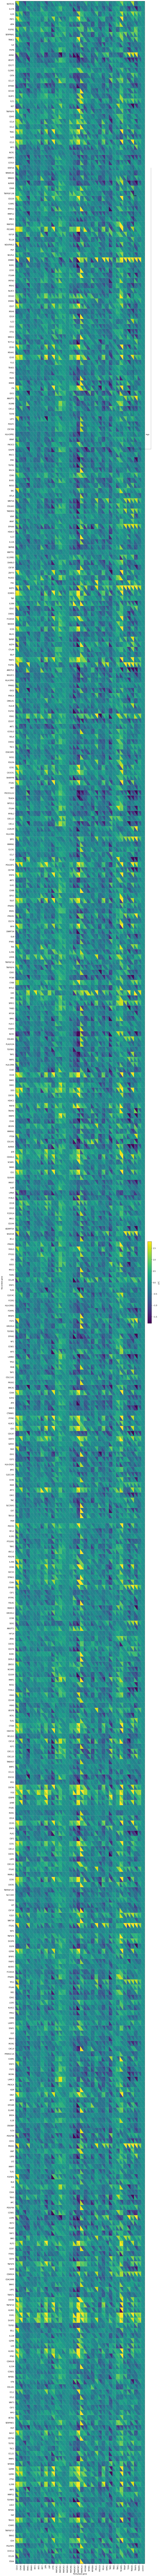

In [8]:
# === Fig 4B–style split-triangle heat map (LOW vs HIGH density) ===
# Inputs (tab-delimited, rows=recorded genes, cols=perturbed genes):
#   outputs/tumor_low_FRP_LFCs.txt
#   outputs/tumor_high_FRP_LFCs.txt
# Output:
#   outputs/heatmap_fig4B_density.png

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap

LOW_PATH  = "outputs/tumor_low_FRP_LFCs.txt"
HIGH_PATH = "outputs/tumor_high_FRP_LFCs.txt"
OUT_PNG   = "outputs/heatmap_fig4B_density.png"

# --- load effect matrices ---
assert os.path.exists(LOW_PATH),  f"Missing: {LOW_PATH}"
assert os.path.exists(HIGH_PATH), f"Missing: {HIGH_PATH}"

M_low  = pd.read_csv(LOW_PATH,  sep="\t", index_col=0)
M_high = pd.read_csv(HIGH_PATH, sep="\t", index_col=0)

# Align to common rows/cols, keep the order from the LOW file
rows = [g for g in M_low.index if g in set(M_high.index)]
cols = [g for g in M_low.columns if g in set(M_high.columns)]
assert rows and cols, "No overlap between low/high matrices."

L = M_low.loc[rows, cols].copy()
H = M_high.loc[rows, cols].copy()

# Save the exact order used
with open("row_order.txt","w") as f: f.write("\n".join(rows) + "\n")
with open("col_order.txt","w") as f: f.write("\n".join(cols) + "\n")

# --- symmetric, robust color scale (like the paper) ---
stack = pd.concat([L.stack(), H.stack()])
vmax = float(np.nanpercentile(np.abs(stack), 99)) if not stack.empty else 1.0
if vmax <= 0: vmax = 1.0
norm = Normalize(vmin=-vmax, vmax=vmax)
cmap = get_cmap(None)  # default colormap

# --- draw split triangles: UL=LOW, LR=HIGH ---
R, C = L.shape
fig_w = max(6.0, 0.35 * C)
fig_h = max(6.0, 0.40 * R)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

for i in range(R):
    for j in range(C):
        x, y = j, R - 1 - i
        # upper-left (LOW)
        v_lo = L.iat[i, j]
        if not pd.isna(v_lo):
            ax.add_patch(Polygon([(x, y+1), (x+1, y+1), (x, y)],
                                 closed=True, facecolor=cmap(norm(v_lo)), edgecolor="none"))
        # lower-right (HIGH)
        v_hi = H.iat[i, j]
        if not pd.isna(v_hi):
            ax.add_patch(Polygon([(x+1, y), (x+1, y+1), (x, y)],
                                 closed=True, facecolor=cmap(norm(v_hi)), edgecolor="none"))

# thin grid + labels (use dataset order exactly)
for jj in range(C+1): ax.plot([jj, jj], [0, R], lw=0.5, color="black", alpha=0.2)
for ii in range(R+1): ax.plot([0, C], [ii, ii], lw=0.5, color="black", alpha=0.2)
ax.set_xlim(0, C); ax.set_ylim(0, R); ax.invert_yaxis()
ax.set_xticks(np.arange(C)+0.5); ax.set_yticks(np.arange(R)+0.5)
ax.set_xticklabels(cols, rotation=90, ha="center")
ax.set_yticklabels(list(reversed(rows)))
ax.set_xlabel("Perturbed gene")
ax.set_ylabel("Recorded gene")

# colorbar + tiny legend indicating triangle orientation
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02); cbar.set_label("LFC")

leg = fig.add_axes([0.82, 0.82, 0.12, 0.12]); leg.axis("off")
leg.text(0.00, 0.90, "Low",  fontsize=9)   # upper-left
leg.text(0.70, 0.05, "High", fontsize=9)   # lower-right
# optional right-angle cue
leg.plot([0,1],[0,0], color="k", alpha=0.3); leg.plot([1,1],[0,1], color="k", alpha=0.3); leg.plot([0,0],[0,1], color="k", alpha=0.3)

plt.tight_layout()
os.makedirs(os.path.dirname(OUT_PNG), exist_ok=True)
plt.savefig(OUT_PNG, dpi=300, bbox_inches="tight")
print("Saved:", OUT_PNG)
print("Also wrote: row_order.txt, col_order.txt")


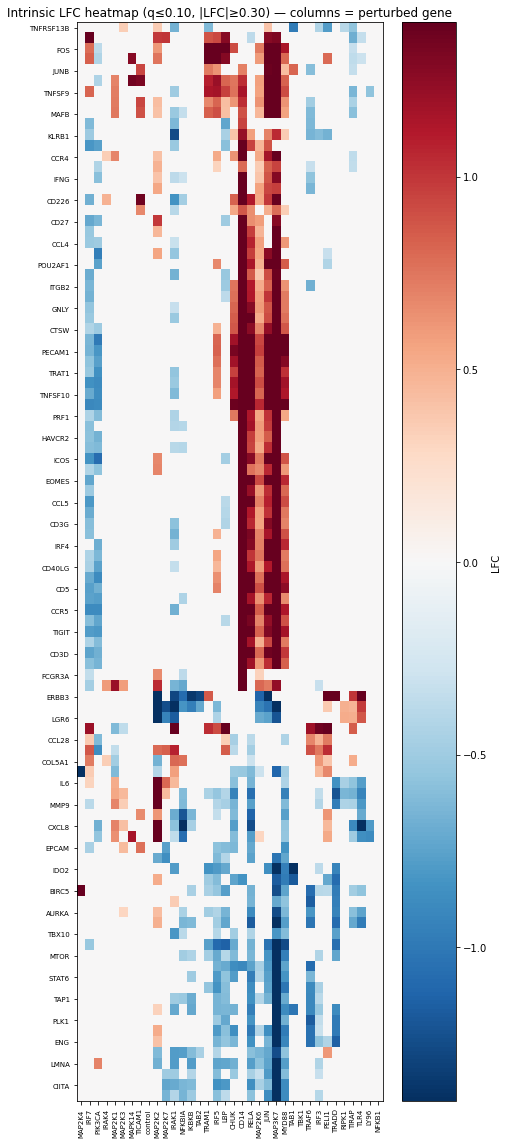

In [2]:
%matplotlib inline
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import squareform

PREFIX   = "outputs/tumor_FRP"
LFC_F    = f"{PREFIX}_LFCs.txt"
QVAL_F   = f"{PREFIX}_qvals.txt"

LFC_THR  = 0.30         # paper uses q≤0.10; LFC floor keeps structure crisp
Q_THR    = 0.10
TOP_GENES, MAX_PERTS = 100, 300

def order_by_cluster(df, axis=0, seed=0):
    A = df.values if axis==0 else df.values.T
    A = A + 1e-9*np.random.default_rng(seed).standard_normal(A.shape)
    corr = np.corrcoef(A); dist = np.clip(1 - corr, 0, None)
    Z = linkage(squareform(dist, checks=False), method="average")  # UPGMA
    return leaves_list(Z)

lfc = pd.read_csv(LFC_F, sep="\t", index_col=0)
if os.path.exists(QVAL_F):
    qv = pd.read_csv(QVAL_F, sep="\t", index_col=0).reindex_like(lfc)
else:
    qv = pd.DataFrame(index=lfc.index, columns=lfc.columns, dtype=float)
    for c in lfc.columns:
        r = lfc[c].abs().rank(ascending=False, method="average")
        qv[c] = np.minimum(1.0, r/len(r))

# select a readable subset for plotting
sel_genes = lfc.abs().max(axis=1).sort_values(ascending=False).head(TOP_GENES).index
lfc_g, qv_g = lfc.loc[sel_genes].copy(), qv.loc[sel_genes].copy()
if lfc_g.shape[1] > MAX_PERTS:
    sig_counts = ((lfc_g.abs()>=LFC_THR) & (qv_g<=Q_THR)).sum(axis=0)
    keep = sig_counts.sort_values(ascending=False).head(MAX_PERTS).index
    lfc_g, qv_g = lfc_g[keep], qv_g[keep]

# mask by paper threshold: q≤0.10; set others to 0 so white under diverging cmap
M = lfc_g.where((qv_g<=Q_THR) & (lfc_g.abs()>=LFC_THR), other=0.0)

# cluster rows/cols
ri, ci = order_by_cluster(M, 0), order_by_cluster(M, 1)
M = M.iloc[ri, ci]

# draw (zero-centered red/blue)
vmax = max(1.0, np.nanpercentile(np.abs(M.values), 95))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

fig_w = min(6 + 0.02*M.shape[1], 22)
fig_h = min(6 + 0.10*M.shape[0], 18)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
im = ax.imshow(M.values, aspect="auto", cmap="RdBu_r", norm=norm)

# tidy ticks
mx = max(1, M.shape[1]//50); my = max(1, M.shape[0]//50)
xt = list(range(0, M.shape[1], mx)); yt = list(range(0, M.shape[0], my))
ax.set_xticks(xt); ax.set_xticklabels(M.columns[xt], rotation=90, fontsize=7)
ax.set_yticks(yt); ax.set_yticklabels(M.index[yt], fontsize=7)

ax.set_title("Intrinsic LFC heatmap (q≤0.10, |LFC|≥0.30) — columns = perturbed gene")
plt.colorbar(im, ax=ax, label="LFC"); plt.tight_layout(); plt.show()

In [ ]:
# === Treated vs Control UMAP (and optional spatial scatter) ===
%matplotlib inline
import numpy as np, pandas as pd, anndata as ad, scanpy as sc
import matplotlib.pyplot as plt

H5AD_F   = "counts.h5ad"
PERT_TSV = "perturb_matrix.tsv"

# 1) Load perturbation matrix and derive labels
P = pd.read_csv(PERT_TSV, sep="\t")
assert "Cell_Barcode" in P.columns, "perturb_matrix.tsv must have 'Cell_Barcode' column."

# Handle both 'control' and 'Control'
ctrl_col = "control" if "control" in P.columns else ("Control" if "Control" in P.columns else None)
pert_cols = [c for c in P.columns if c not in ("Cell_Barcode", "control", "Control")]

treated_mask = (P[pert_cols].sum(axis=1) > 0).to_numpy()
if ctrl_col is not None:
    control_mask = (P[ctrl_col].to_numpy() == 1) & (~treated_mask)
else:
    control_mask = (~treated_mask)  # all-zero row => control

labels = np.where(treated_mask, "treated", np.where(control_mask, "control", "unknown"))
P["ctrl_treat"] = labels

print("Counts:", dict(pd.Series(labels).value_counts()))

# 2) Load counts and align to perturbation order
adata = ad.read_h5ad(H5AD_F)
adata = adata[P["Cell_Barcode"].astype(str)].copy()
adata.obs["ctrl_treat"] = pd.Categorical(P["ctrl_treat"].values, categories=["control","treated","unknown"], ordered=True)

# 3) UMAP embedding (standard Scanpy pipeline)
sc.settings.verbosity = 0
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]].copy()
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

# 4) Plot UMAP
title = f"UMAP: control vs treated  (control={(labels=='control').sum()}, treated={(labels=='treated').sum()}, unknown={(labels=='unknown').sum()})"
sc.pl.umap(adata, color="ctrl_treat", title=title, size=8, frameon=False, show=True)
# To save as PNG too:
# sc.pl.umap(adata, color="ctrl_treat", title=title, size=8, frameon=False, show=False, save="_ctrl_treat.png")

# 5) OPTIONAL: spatial XY scatter if X/Y present in adata.obs
if {"X","Y"}.issubset(adata.obs.columns):
    fig, ax = plt.subplots(figsize=(6,6))
    for group, df in adata.obs.groupby("ctrl_treat"):
        ax.scatter(df["X"], df["Y"], s=5, alpha=0.6, label=group)
    ax.set_title("Spatial scatter: control vs treated")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.legend(markerscale=2, frameon=False)
    plt.tight_layout(); plt.show()

Counts: {'treated': 5168, 'control': 4264}


/u/jchen67/.local/share/mamba/envs/frp/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
